In [160]:
import pandas as pd
import numpy as np
from scipy import interp

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

from data_scraper import PullData

import xgboost as xg
from xgboost.sklearn import XGBClassifier

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, auc

seed = 26

In [12]:
demand_data, weather_data = PullData() #delete old #download new

Checking for missing data...
Done.
Pulling IESO Demand Data...
2016
100% [............................................................................] 233991 / 2339912017
100% [............................................................................] 233352 / 2333522018
100% [............................................................................] 107740 / 107740Done.
Pulling Statscan Weather Data for Station 31688...
2016
-1 / unknown2017
-1 / unknown2018
-1 / unknownDone.
Reading demand csvs to dataframe...
Done.
Reading weather csvs to dataframe...
Done.


# Demand Data Features

In [392]:
df = demand_data.copy()

In [393]:
del df['Market Demand']

In [394]:
df.head()

,Date,Hour,Ontario Demand
0,2016-01-01,1,13417
1,2016-01-01,2,12968
2,2016-01-01,3,12395
3,2016-01-01,4,12228
4,2016-01-01,5,12116


In [395]:
df = pd.pivot_table(df,index=['Date'],columns=['Hour'],values=['Ontario Demand'])

In [396]:
df.reset_index(inplace=True)

In [397]:
df['Date'] = pd.to_datetime(df['Date'])

In [398]:
df['Demand_Max'] = df.max(axis=1)
df['Demand_Mean'] = df.mean(axis=1)
df['Demand_Min'] = df.min(axis=1)

In [399]:
mapper = {1:'Demand_1',2:'Demand_2',3:'Demand_3',4:'Demand_4',5:'Demand_5',6:'Demand_6',7:'Demand_7',8:'Demand_8',9:'Demand_9',
          10:'Demand_10',11:'Demand_11',12:'Demand_12',13:'Demand_13',14:'Demand_14',15:'Demand_15',16:'Demand_16',17:'Demand_17',
          18:'Demand_18',19:'Demand_19',20:'Demand_20',21:'Demand_21',22:'Demand_22',23:'Demand_23',24:'Demand_24'}
df = df.rename(columns=mapper)

# Add Date Features

In [400]:
df['Month'] = df['Date'].apply(lambda x: x.month)
df['Dayofweek'] = df['Date'].apply(lambda x: x.dayofweek)
df['Day'] = df['Date'].apply(lambda x: x.day)
df['Year'] = df['Date'].apply(lambda x: x.year)

# Add Top Days Feature {0,1}

In [401]:
top_days = 5

df['topdays'] = 0


for year in range(int(df['Year'].min()),int(df['Year'].max())+1):

    indices = df[df['Year'] == year].nlargest(top_days,'Demand_Max').index

    df.loc[indices, 'topdays'] = 1

In [402]:
df[df['topdays']==1].head(20)

Date Ontario Demand                                               \
Hour                  Demand_1 Demand_2 Demand_3 Demand_4 Demand_5 Demand_6   
194  2016-07-13          15815    15130    14625    14461    14880    15941   
222  2016-08-10          15805    15169    14782    14636    14978    15939   
223  2016-08-11          17091    16271    15769    15456    15744    16536   
224  2016-08-12          17301    16702    16262    16235    16594    17587   
250  2016-09-07          15709    15054    14857    14800    15106    16422   
528  2017-06-12          14146    13568    13226    13071    13420    14600   
565  2017-07-19          13987    13308    12880    12872    13307    14188   
632  2017-09-24          13832    13348    12935    12661    12612    12819   
633  2017-09-25          14556    14125    13789    13684    14147    15539   
634  2017-09-26          14858    14246    13831    13841    14285    15522   
735  2018-01-05          17475    16808    16679    16620    16706    17173   
736  2018-01-06          17293    16937    16505    16599    16647    16764   
737  2018-01-07          17015    16531    16240    16103    16031    16095   
878  2018-05-28          13168    12724    12653    12465    12815    13651   
899  2018-06-18          15572    15196    14618    14652    14925    16022   

                                  ...                       Demand_Max  \
Hour Demand_7 Demand_8 Demand_9   ...   Demand_23 Demand_24              
194     17498    18836    19742   ...       19383     17835      22659   
222     17353    18869    19910   ...       19675     18128      23100   
223     17797    19210    20322   ...       19896     18510      22812   
224     19070    20390    21318   ...       18944     17591      22402   
250     17991    18816    19716   ...       18673     17337      23213   
528     16503    17223    18028   ...       17931     16608      21168   
565     15632    16611    17244   ...       17140     15578      20627   
632     13279    14183    15453   ...       16517     15288      20457   
633     16990    17544    18224   ...       17191     15317      21786   
634     17021    17631    18340   ...       16955     15675      21542   
735     18123    19177    19660   ...       18914     18064      20906   
736     17155    17841    18703   ...       18723     17819      20768   
737     16439    16797    17181   ...       17172     16221      20429   
878     15379    16427    17082   ...       16786     15507      20473   
899     18202    19874    20718   ...       16925     15493      21369   

     Demand_Mean Demand_Min Month Dayofweek Day  Year topdays  
Hour                                                           
194     19645.36    14461.0     7         2  13  2016       1  
222     19794.92    14636.0     8         2  10  2016       1  
223     20220.00    15456.0     8         3  11  2016       1  
224     20224.76    16235.0     8         4  12  2016       1  
250     19784.84    14800.0     9         2   7  2016       1  
528     18094.04    13071.0     6         0  12  2017       1  
565     17549.44    12872.0     7         2  19  2017       1  
632     16924.20    12612.0     9         6  24  2017       1  
633     18437.04    13684.0     9         0  25  2017       1  
634     18445.68    13831.0     9         1  26  2017       1  
735     19038.44    16620.0     1         4   5  2018       1  
736     18604.48    16505.0     1         5   6  2018       1  
737     17889.72    16031.0     1         6   7  2018       1  
878     17152.12    12465.0     5         0  28  2018       1  
899     18837.48    14618.0     6         0  18  2018       1  

[15 rows x 33 columns]

In [509]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 906 entries, 0 to 905
Data columns (total 32 columns):
(Date, )                       906 non-null datetime64[ns]
(Ontario Demand, Demand_1)     906 non-null int64
(Ontario Demand, Demand_2)     906 non-null int64
(Ontario Demand, Demand_3)     906 non-null int64
(Ontario Demand, Demand_4)     906 non-null int64
(Ontario Demand, Demand_5)     906 non-null int64
(Ontario Demand, Demand_6)     906 non-null int64
(Ontario Demand, Demand_7)     906 non-null int64
(Ontario Demand, Demand_8)     906 non-null int64
(Ontario Demand, Demand_9)     906 non-null int64
(Ontario Demand, Demand_10)    906 non-null int64
(Ontario Demand, Demand_11)    906 non-null int64
(Ontario Demand, Demand_12)    906 non-null int64
(Ontario Demand, Demand_13)    906 non-null int64
(Ontario Demand, Demand_14)    906 non-null int64
(Ontario Demand, Demand_15)    906 non-null int64
(Ontario Demand, Demand_16)    906 non-null int64
(Ontario Demand, Demand_17)    906 n

In [403]:
del df['Year']

# Weather Data Features

In [486]:
df2 = weather_data.copy()

In [487]:
df2['Date/Time'] = pd.to_datetime(df2['Date/Time'])

In [488]:
df2['Hour'] = df2['Date/Time'].apply(lambda x: x.hour)

In [489]:
df2['Date/Time'] = df2['Date/Time'].dt.date

In [490]:
df2['Date/Time'] = pd.to_datetime(df2['Date/Time'])

In [491]:
df2 = df2.rename(index=str, columns = {"Date/Time":"Date"})

In [492]:
df_temp = df2[['Date','Temp (°C)','Hour']]
df_hum = df2[['Date','Rel Hum (%)','Hour']]
df_press = df2[['Date','Stn Press (kPa)','Hour']]

In [493]:
df_temp = pd.pivot_table(df_temp,index=['Date'],columns=['Hour'],values=['Temp (°C)'])
df_hum = pd.pivot_table(df_hum,index=['Date'],columns=['Hour'],values=['Rel Hum (%)'])
df_press = pd.pivot_table(df_press,index=['Date'],columns=['Hour'],values=['Stn Press (kPa)'])

In [494]:
df_temp.reset_index(inplace=True)
df_hum.reset_index(inplace=True)
df_press.reset_index(inplace=True)

In [495]:
df_temp['temp_Max'] = df_temp.max(axis=1)
df_temp['temp_Mean'] = df_temp.mean(axis=1)
df_temp['temp_Min'] = df_temp.min(axis=1)

df_hum['hum_Max'] = df_hum.max(axis=1)
df_hum['hum_Mean'] = df_hum.mean(axis=1)
df_hum['hum_Min'] = df_hum.min(axis=1)

df_press['press_Max'] = df_press.max(axis=1)
df_press['press_Mean'] = df_press.mean(axis=1)
df_press['press_Min'] = df_press.min(axis=1)

In [496]:
mapper_temp = {0:'temp_0',1:'temp_1',2:'temp_2',3:'temp_3',4:'temp_4',5:'temp_5',6:'temp_6',7:'temp_7',8:'temp_8',9:'temp_9',
          10:'temp_10',11:'temp_11',12:'temp_12',13:'temp_13',14:'temp_14',15:'temp_15',16:'temp_16',17:'temp_17',
          18:'temp_18',19:'temp_19',20:'temp_20',21:'temp_21',22:'temp_22',23:'temp_23'}

mapper_hum = {0:'hum_0', 1:'hum_1',2:'hum_2',3:'hum_3',4:'hum_4',5:'hum_5',6:'hum_6',7:'hum_7',8:'hum_8',9:'hum_9',
          10:'hum_10',11:'hum_11',12:'hum_12',13:'hum_13',14:'hum_14',15:'hum_15',16:'hum_16',17:'hum_17',
          18:'hum_18',19:'hum_19',20:'hum_20',21:'hum_21',22:'hum_22',23:'hum_23'}

mapper_press = {0:'press_0', 1:'press_1',2:'press_2',3:'press_3',4:'press_4',5:'press_5',6:'press_6',7:'press_7',8:'press_8',9:'press_9',
          10:'press_10',11:'press_11',12:'press_12',13:'press_13',14:'press_14',15:'press_15',16:'press_16',17:'press_17',
          18:'press_18',19:'press_19',20:'press_20',21:'press_21',22:'press_22',23:'press_23'}


df_temp = df_temp.rename(columns=mapper_temp)
df_hum = df_hum.rename(columns=mapper_hum)
df_press = df_press.rename(columns=mapper_press)

# Merge Weather/Demand Dataframes

In [500]:
data = pd.merge(df, df_temp, how='left', on='Date')
data = pd.merge(data, df_hum, how='left', on='Date')
data = pd.merge(data, df_press, how='left', on='Date')

In [501]:
data.head()

Date Ontario Demand                                               \
Hour                  Demand_1 Demand_2 Demand_3 Demand_4 Demand_5 Demand_6   
0    2016-01-01          13417    12968    12395    12228    12116    12257   
1    2016-01-02          13251    12844    12673    12473    12468    12644   
2    2016-01-03          13432    12916    12588    12450    12443    12624   
3    2016-01-04          14809    14480    14295    14213    14435    15147   
4    2016-01-05          16429    15996    15916    15878    15947    16466   

                                   ...    Stn Press (kPa)                    \
Hour Demand_7 Demand_8 Demand_9    ...           press_17 press_18 press_19   
0       12528    12820    12986    ...             100.14   100.19   100.25   
1       13064    13780    14305    ...              99.75    99.76    99.70   
2       12973    13613    14155    ...             100.07   100.21   100.30   
3       16532    18240    18522    ...             101.91   101.98   102.05   
4       17974    19374    19356    ...             101.91   101.86   101.85   

                                         press_Max press_Mean press_Min  
Hour press_20 press_21 press_22 press_23                                 
0      100.28   100.30   100.33   100.30    100.38   100.2052    100.02  
1       99.60    99.44    99.35    99.28    100.34    99.9536     99.28  
2      100.43   100.49   100.56   100.63    100.63    99.7184     99.13  
3      102.12   102.17   102.24   102.25    102.25   101.5284    100.65  
4      101.87   101.84   101.79   101.75    102.44   102.1600    101.75  

[5 rows x 113 columns]

In [510]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 906 entries, 0 to 905
Data columns (total 111 columns):
(Ontario Demand, Demand_1)     int64
(Ontario Demand, Demand_2)     int64
(Ontario Demand, Demand_3)     int64
(Ontario Demand, Demand_4)     int64
(Ontario Demand, Demand_5)     int64
(Ontario Demand, Demand_6)     int64
(Ontario Demand, Demand_7)     int64
(Ontario Demand, Demand_8)     int64
(Ontario Demand, Demand_9)     int64
(Ontario Demand, Demand_10)    int64
(Ontario Demand, Demand_11)    int64
(Ontario Demand, Demand_12)    int64
(Ontario Demand, Demand_13)    int64
(Ontario Demand, Demand_14)    int64
(Ontario Demand, Demand_15)    int64
(Ontario Demand, Demand_16)    int64
(Ontario Demand, Demand_17)    int64
(Ontario Demand, Demand_18)    int64
(Ontario Demand, Demand_19)    int64
(Ontario Demand, Demand_20)    int64
(Ontario Demand, Demand_21)    int64
(Ontario Demand, Demand_22)    int64
(Ontario Demand, Demand_23)    int64
(Ontario Demand, Demand_24)    int64
(Deman

# Build and Validate Model

In [502]:
y = data['topdays']

del data['Date']

del data['topdays']

In [503]:
X = data

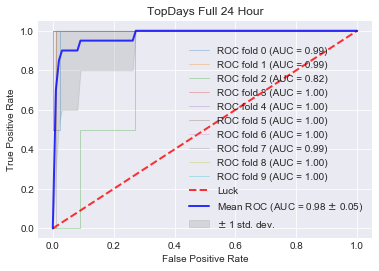

In [507]:
# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves

default_params = {
    'objective': 'binary:logistic',
    'max_depth': 6,
    'learning_rate': 0.21, 
    'silent': 1.0,
    'scale_pos_weight': float(np.sum(y == 0)) / np.sum(y == 1),
    'n_estimators': 40
}

cv = StratifiedKFold(n_splits=10)
classifier = XGBClassifier(**default_params, seed = seed)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in cv.split(X, y):
    probas_ = classifier.fit(X.loc[train], y.loc[train]).predict_proba(X.loc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y.loc[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('TopDays Full 24 Hour')
plt.legend(loc="lower right")

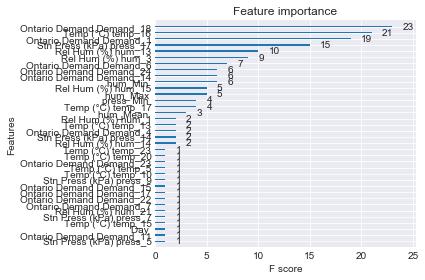

In [515]:
xg.plot_importance(classifier)
plt.tight_layout()